In [ ]:
!pip install pywapor --quiet

### Whittaker Interpolation

We start by importing a couple of modules we need for this exercise and defining a folder in which to work.

In [48]:
from pywapor.enhancers.smooth.whittaker import whittaker_smoothing
from pywapor.collect.protocol.crawler import download_url
import os
import numpy as np
import altair as alt
import xarray as xr

workdir = "/Users/hmcoerver/Desktop"

Next we download some example data.

In [49]:
fp = download_url("https://storage.googleapis.com/fao-cog-data/exercise/data.nc", os.path.join(workdir, "data.nc"))

We can open this data using XArray.

In [50]:
ds = xr.open_dataset(fp)
ds

<xarray.Dataset> Size: 46MB
Dimensions:  (x: 150, y: 150, time: 257)
Coordinates:
  * x        (x) float64 1kB 29.42 29.42 29.42 29.42 ... 29.45 29.45 29.45 29.45
  * y        (y) float64 1kB 30.88 30.88 30.88 30.88 ... 30.85 30.85 30.85 30.85
  * time     (time) datetime64[ns] 2kB 2021-01-01T08:42:49 ... 2023-01-09
Data variables:
    ndvi     (time, y, x) float64 46MB ...
    sensor   (time) int64 2kB ...
Attributes:
    LC08_SR:       0
    LC09_SR:       1
    LE07_SR:       2
    MOD13Q1.061:   3
    MYD13Q1.061:   4
    S2MSI2A_R20m:  5

Above you can see that the dataset contains 150x150 pixels for 257 different moments in time. It contains two variables, `ndvi` and `sensor`. The `ndvi` is three dimensional, while `sensor` is one dimensional.

To get an idea of what we are working with, lets make a quick plot to for a random time (at index = 50, feel free to change it!).

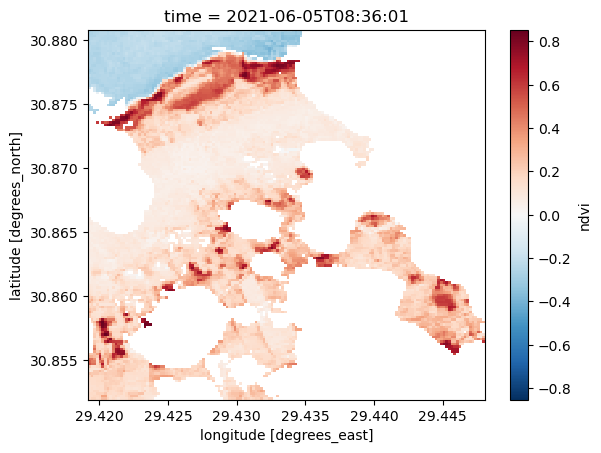

In [60]:
ds["ndvi"].isel(time=50).plot()

Besides looking at a (spatial) map of the data, we can also look at a single pixel. We'll start with the middle pixel (but again, feel free to change it), i.e. the 75th pixel in the x and y direction.

In [53]:
# Define for which pixel we create a timeseries plot.
xpixel = 75
ypixel = 75

# Convert the XArray dataset to a pandas Dataframe.
df_in = ds.isel(x = xpixel, y = ypixel, drop = True).to_dataframe().reset_index()
df_in = df_in.replace({v: k for k, v in ds.attrs.items()})

# Create an Altair (interactive) plot.
point_chart = alt.Chart(df_in).mark_point().encode(
    x = "time:T",
    y = "ndvi:Q",
    color = "sensor:N",
    tooltip = ["time:T", "ndvi:Q", "sensor:N"]
)
point_chart.interactive()

alt.Chart(...)

Now that we have an idea of what we are working with, lets run the smoothing algorithm.

In [54]:
# Define sensor specific weights, we'll start by leaving this set to None.
weights = None
# weights = {'LC08_SR': 0.0,
#     'LC09_SR': 0.0,
#     'LE07_SR': 0.0,
#     'MOD13Q1.061': 0.5,
#     'MYD13Q1.061': 0.5,
#     'S2MSI2A_R20m': 0.0
#     }

out = whittaker_smoothing(ds, "ndvi", lmbdas = 100, weights = weights, a = 0.5, max_iter = 10, valid_drange = [-np.inf, np.inf]).compute()
out

<xarray.Dataset> Size: 46MB
Dimensions:        (y: 150, x: 150, time: 257)
Coordinates:
  * x              (x) float64 1kB 29.42 29.42 29.42 29.42 ... 29.45 29.45 29.45
  * y              (y) float64 1kB 30.88 30.88 30.88 30.88 ... 30.85 30.85 30.85
  * time           (time) datetime64[ns] 2kB 2021-01-01T08:42:49 ... 2023-01-09
Data variables:
    ndvi_smoothed  (time, y, x) float64 46MB -0.3563 -0.3625 ... 0.2648 0.2657
Attributes:
    LC08_SR:       0
    LC09_SR:       1
    LE07_SR:       2
    MOD13Q1.061:   3
    MYD13Q1.061:   4
    S2MSI2A_R20m:  5

Finally we can create a chart for the smoothed data.

In [55]:
df = out.isel(x=xpixel, y=ypixel, drop=True).to_dataframe().reset_index()

line_chart = alt.Chart(df).mark_line().encode(
    x = "time:T",
    y = "ndvi_smoothed:Q",
)

chart = point_chart + line_chart
chart.interactive()

alt.LayerChart(...)

And we can also look at the "same" map we created earlier again, you'll see that the gaps have been filled.

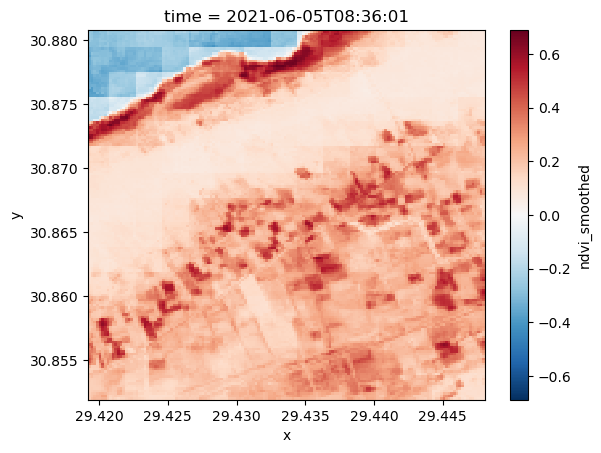

In [61]:
out["ndvi_smoothed"].isel(time=50).plot()